# Visualization for Delegation Based Lock

In [1]:
@time using DataFrames, CSV

bench = @time CSV.read("output/output.csv", DataFrame)
bench.Locktype = first.(split.(bench.Locktype, "|"))


  3.064610 seconds (1.51 M allocations: 91.178 MiB, 1.79% gc time, 0.39% compilation time)


  1.450195 seconds (982.17 k allocations: 65.672 MiB, 2.08% gc time, 99.49% compilation time: 53% of which was recompilation)


2142-element Vector{SubString{String}}:
 "Flat Combining (SkipList)"
 "Flat Combining (SkipList)"
 "Flat Combining (SkipList)"
 "Flat Combining (SkipList)"
 "Flat Combining"
 "Flat Combining"
 "Flat Combining"
 "Flat Combining"
 "Flat Combining Fair"
 "Flat Combining Fair"
 ⋮
 "RCL"
 "RCL"
 "RCL"
 "RCL"
 "RCL"
 "RCL"
 "RCL"
 "RCL"
 "RCL"

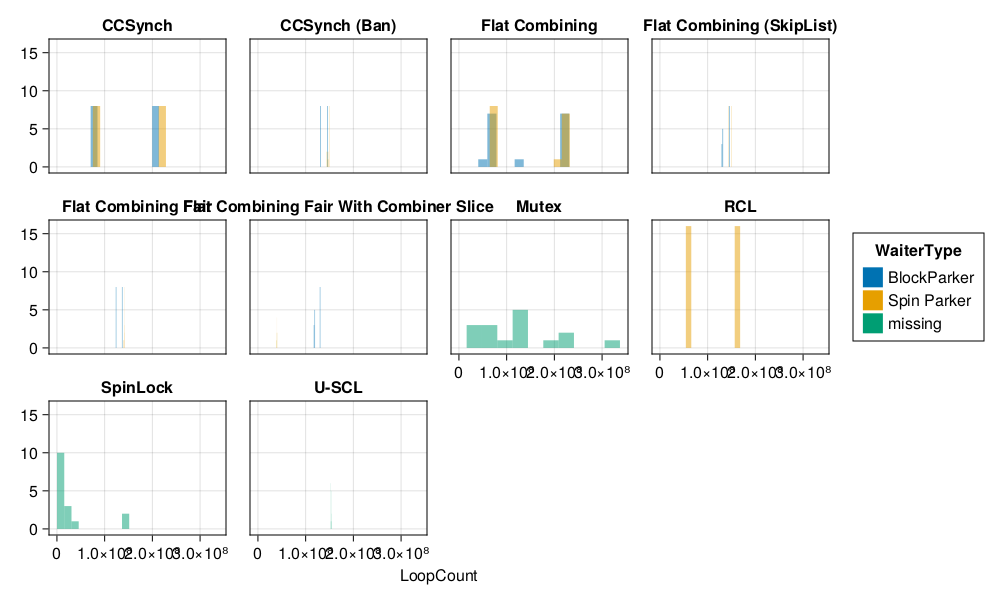

In [7]:
using AlgebraOfGraphics, CairoMakie
using AlgebraOfGraphics: density
using Tidier

CairoMakie.activate!(type = "svg")



loop_comparison = ((@chain bench begin
        Tidier.@filter(ThreadNum == 16)
end) |> data) * mapping(:LoopCount, layout = :Locktype, color = :WaiterType => nonnumeric) * (visual(Hist, bins=10, alpha=0.5))
    
# savefig(loop_comparison, "graphs/loop_comparison.svg")
fig = draw(loop_comparison, figure=(resolution=(1000,600),))

save("graphs/loop_comparison_per_thread_histogram.svg", fig)

fig

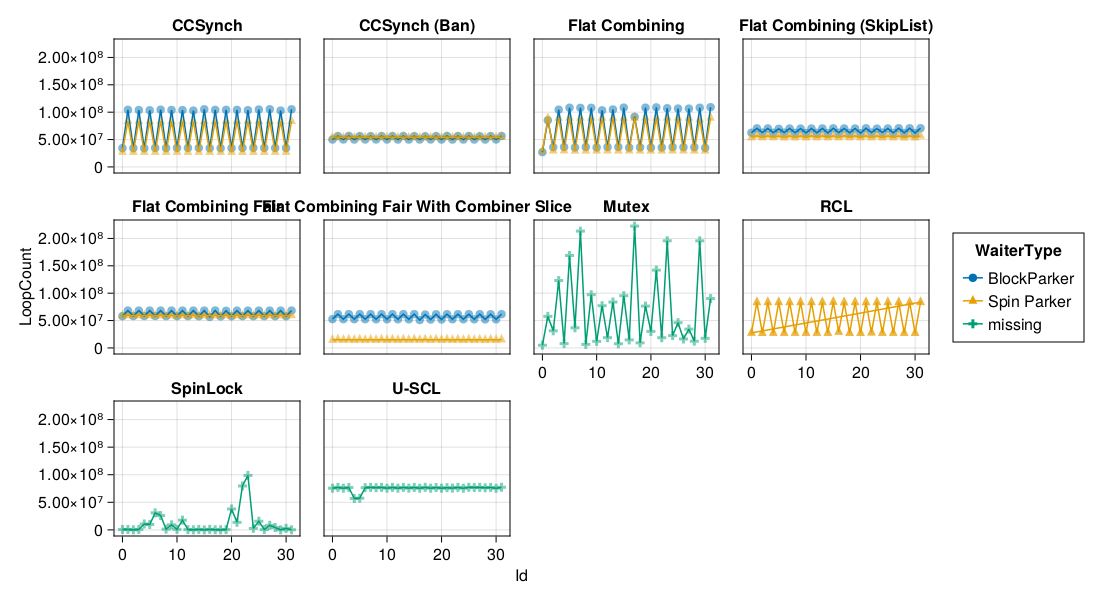

In [3]:
using AlgebraOfGraphics, CairoMakie
using AlgebraOfGraphics: density
using Tidier

CairoMakie.activate!(type = "svg")


loop_comparison = ((@chain bench begin
        Tidier.@filter(ThreadNum == 32)
end) |> data) * mapping(:Id, :LoopCount, layout = :Locktype, color = :WaiterType, marker = :WaiterType) * (visual(Scatter, alpha = 0.5) + visual(Lines))
    
# savefig(loop_comparison, "graphs/loop_comparison.svg")
fig = draw(loop_comparison, figure = (resolution = (1100,600),))

save("graphs/loop_comparison_per_thread.svg", fig)

fig

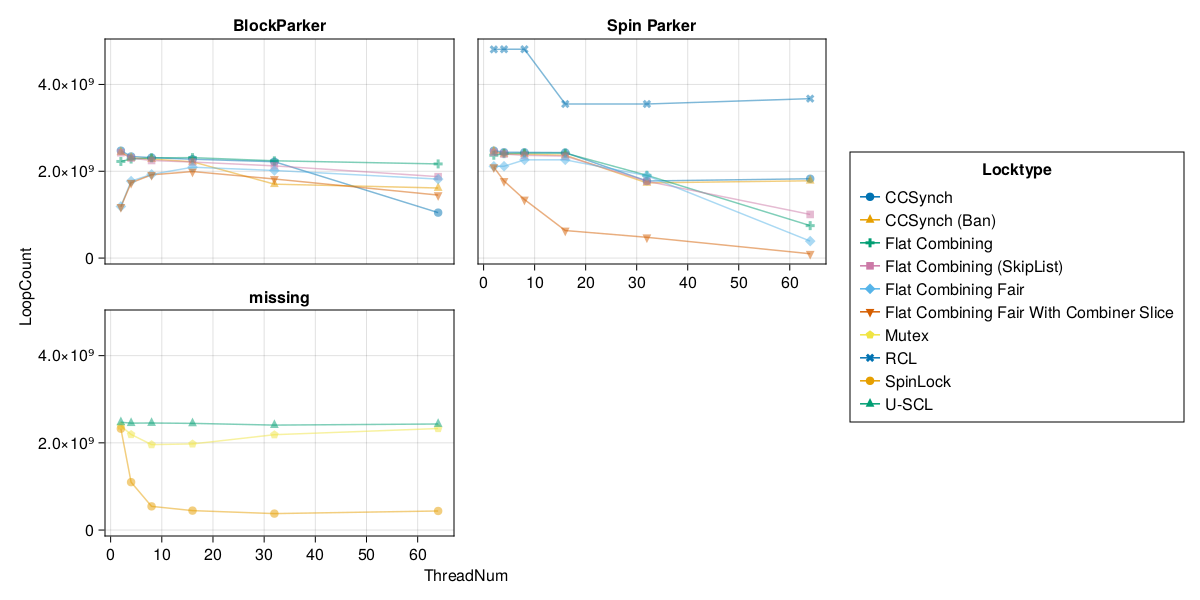

In [11]:
using Tidier
using AlgebraOfGraphics, CairoMakie

bench2 = @chain bench begin
    @group_by(Locktype, WaiterType, ThreadNum)
    @summarise(LoopCount = sum(LoopCount))
    @ungroup
end

plt = data(bench2) * mapping(:ThreadNum, :LoopCount, marker = :Locktype, color = :Locktype, layout = :WaiterType) * (visual(Lines, alpha=0.5) + visual(Scatter, alpha=0.5))

fig = draw(plt, figure = (resolution=(1200,600),))

save("graphs/loop_comparison_together.svg", fig)

fig

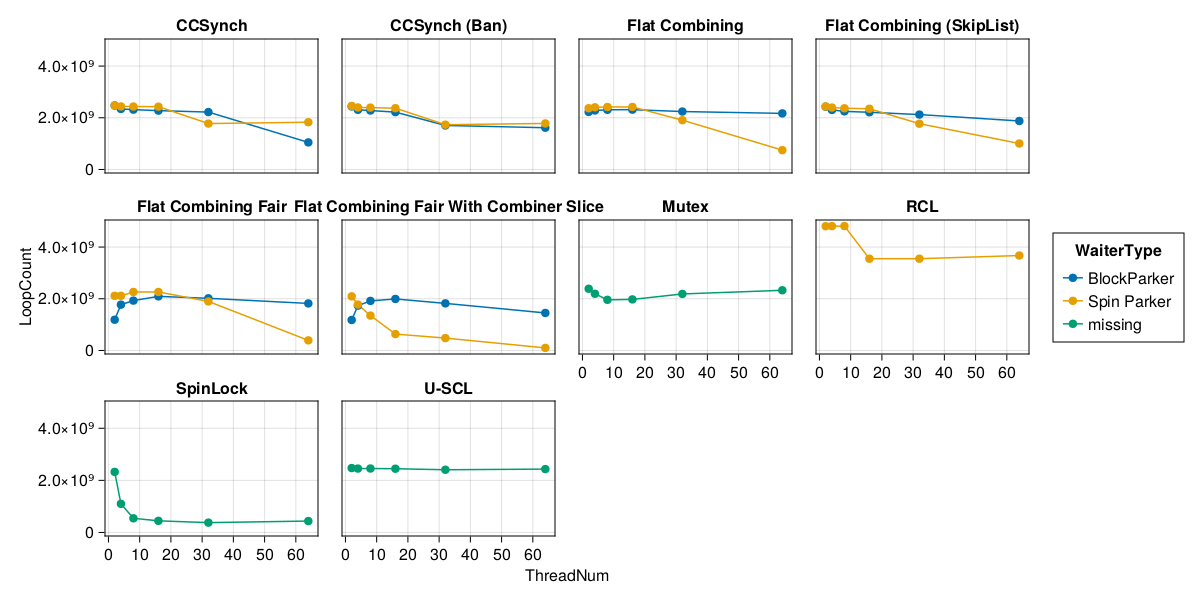

In [12]:
using Tidier
using AlgebraOfGraphics, CairoMakie

bench2 = @chain bench begin
    @group_by(Locktype, WaiterType, ThreadNum)
    @summarise(LoopCount = sum(LoopCount))
    @ungroup
end

plt = data(bench2) * mapping(:ThreadNum, :LoopCount, layout = :Locktype, color = :WaiterType) * (visual(Lines) + visual(Scatter))

fig = draw(plt, figure = (resolution=(1200,600),))

save("graphs/loop_comparison_split.svg", fig)

fig

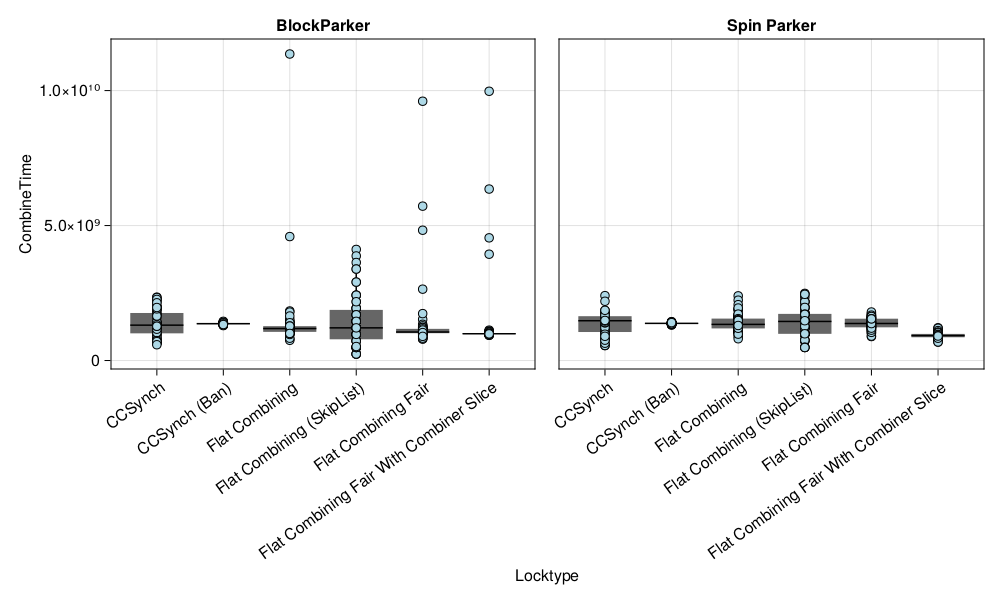

In [14]:
using DataFrames, Tidier, AlgebraOfGraphics, CairoMakie

bench_32thread = @chain dropmissing(bench) begin
    Tidier.@filter(ThreadNum == 64)
end

plt = data(bench_32thread) * mapping(:Locktype, :CombineTime, layout = :WaiterType) * (visual(BoxPlot) + (visual(Scatter, color = "lightblue", strokewidth = 1 )))


fig = draw(plt, axis=(xticklabelrotation=pi/5,), figure = (resolution=(1000,600),))

save("graphs/combining_time_box_plot.svg", fig)

fig